In [6]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
import librosa
import IPython.display as ipd
from scipy.io import savemat, loadmat
import sys
sys.path.append('./tismir-beat-2024/')


from scipy.stats import gmean
from scipy.ndimage import gaussian_filter1d


import librosa
from essentia.standard import Crest
from IPython.display import Audio


# https://github.com/maia-ls/tismir-beat-2024
from rhythmic_features.feature import compute_scale_transform_magnitudes

In [7]:
# Directory containing original field recordings
ORIG_DIR = './data/IEMP-condombe/Media'

# Directory containing Demucs-separated (non-voice) tracks
DEMUCS_DIR = '../separated/htdemucs'

In [8]:
basedir = './data/IEMP-condombe/Media'
filenames = ['UC_211/UC_211_Stereo',
             'UC_212/UC_212_Stereo',
            'UC_213/UC_213_Stereo',
             'UC_221/UC_221_Stereo',
             'UC_222/UC_222_Stereo',
             'UC_231/UC_231_Stereo',
             'UC_232/UC_232_Stereo',
             'UC_241/UC_241_Stereo',
             'UC_242/UC_242_Stereo',
             'UC_311/UC_311_Stereo',
             'UC_231/UC_231_Stereo',
             'UC_312/UC_312_Stereo',
             'UC_321/UC_321_Stereo']

In [9]:
def crest(comps):
    """Compute crest array from NMF templates
    
    Args:
        comps (np.ndarray): NMF components (N x D)
        
    Returns:
        crest (np.ndarray): Crest of each spectral component (1 x D)
    """
    crst = []
    for i in range(comps.shape[1]):
        crst.append(Crest()(comps[:,i]))
    return np.array(crst)

def activation_onset_strength_reconstructed(comps, acts, S, freqs, n_fft=512, hop_length=160, lag=3,
                                            detrend=True, func=np.mean, C=1000):
    """Compute onset strength from reconstructed signal with selected activations
    
    Args:
        comps (np.ndarray): NMF components (N x D)
        acts (np.ndarray): NMF activations (D x M)
        S (np.ndarray): Original spectrogram (F x M)
        freqs (np.ndarray): FFT frequencies (F x 1)
        n_fft (int): Number of FFT points
        hop_length (int): Hop size
        lag (int): Lag for computing onset strength
        detrend (bool): Makes the spectral flux locally zero-meaned (Default value = True)
        func (function): Function for crest-based selection
        C (scalar): Log-compression for computing onset strength
    """
    
    # Selecting components based on crest factor
    crst = crest(comps)
    if isinstance(func, int):
        idx = crst > np.partition(crest(comps), func)[func]
    elif func == 'all':
        idx = np.array([True] * len(crest(comps)))
    else:
        idx = crst >= func(crst)
    
    # Reconstructing spectrogram with selected components
    Ss = np.zeros(S.shape)
    Ss[(freqs >= fmin) & (freqs <= fmax), :] = comps[:,idx].dot(acts[idx,:])
    ys = librosa.istft(Ss * np.exp(1j * np.angle(S)), n_fft=n_fft, hop_length=hop_length)

    # Computing onset strength
    oss = librosa.onset.onset_strength(S=np.log(1+C*Ss), sr=sr/hop_length, lag=lag, detrend=detrend)
    return oss, ys

def activation_onset_strength_reconstructed_ev(comps, acts, ev, S, freqs, n_fft=512, hop_length=160, lag=3,
                                            detrend=True, func=np.mean, C=1000):
    """Compute onset strength from reconstructed signal with selected activations
    
    Args:
        comps (np.ndarray): NMF components (N x D)
        acts (np.ndarray): NMF activations (D x M)
        S (np.ndarray): Original spectrogram (F x M)
        freqs (np.ndarray): FFT frequencies (F x 1)
        n_fft (int): Number of FFT points
        hop_length (int): Hop size
        lag (int): Lag for computing onset strength
        detrend (bool): Makes the spectral flux locally zero-meaned (Default value = True)
        func (function): Function for crest-based selection
        C (scalar): Log-compression for computing onset strength
    """
    
    # Selecting components based on crest factor
    idx = ev
    
    # Reconstructing spectrogram with selected components
    Ss = np.zeros(S.shape)
    Ss[(freqs >= fmin) & (freqs <= fmax), :] = comps[:,idx].dot(acts[idx,:])
    ys = librosa.istft(Ss * np.exp(1j * np.angle(S)), n_fft=n_fft, hop_length=hop_length)

    # Computing onset strength
    oss = librosa.onset.onset_strength(S=np.log(1+C*Ss), sr=sr/hop_length, lag=lag, detrend=detrend)
    return oss, ys

def normalize_minmax(x):
    """Min-max normalization
    
    Args:
        x (nd.array): Data"""
    return (x - x.min()) / (x.max() - x.min())

In [10]:
# Parameters
# Resampling frequency
sr = 16000

# STFT
n_fft = 512
hop_length = 160
fmin = 1600
fmax = 80000
freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
freqs_idx = (freqs >= fmin) & (freqs <= fmax)

# NMF
n_components = 6
max_iter = 12000

# Onset strength
detrend = True
sigma = 1

In [11]:
STM_Dict = {}
STM_mean = []

for filename in filenames:
    x, fs = librosa.load(f'{ORIG_DIR}/{filename}.wav', sr=None, duration=60)
    key = filename.split('_')[2]

    x = librosa.resample(y=x, orig_sr=fs, target_sr=sr)


    S = librosa.stft(y=x, n_fft=n_fft, hop_length=hop_length)
    h, p = librosa.decompose.hpss(S)

    S = p
    Sn = S[freqs_idx, :].copy()

    comps, acts = librosa.decompose.decompose(np.abs(Sn), n_components=n_components, max_iter=max_iter)



    ev = crest(comps) > gmean(crest(comps))

    energies = []
    for act in acts:
        energy = np.sum(act[:500]**2)
        energies.append(energy)

    top_energies_indexes = np.argsort(energies)[-2:]

    ev = [False]*len(ev)
    for i in top_energies_indexes:
        ev[i] = True

    Ss = np.zeros(Sn.shape)
    Ss = comps[:,ev].dot(acts[ev,:])

    Ss = np.zeros(S.shape)
    Ss[(freqs >= fmin) & (freqs <= fmax), :] = comps[:,ev].dot(acts[ev,:])

    o, _ = activation_onset_strength_reconstructed_ev(comps, acts, ev, S, freqs, lag=3, detrend=False, func=gmean)
    o = gaussian_filter1d(o, sigma)

    Rm, _, _, R, _, _ = compute_scale_transform_magnitudes(o=o, sr=sr/hop_length, scale_transform='direct')

    #STM.append(R)
    STM_Dict[key] = R
    STM_mean.append(Rm)
STM_mean = np.vstack(STM_mean)
print(STM_mean.shape)

(13, 1065)


In [ ]:
#print(STM[0].shape)

NameError: name 'STM' is not defined

In [14]:
from umap.umap_ import UMAP

/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
n_neighbors = 70
min_dist = 0.1
metric = 'cosine'
reducer = UMAP(n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric)

In [28]:
# X = []
# group = []
# cdict = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9', 10: 'C10', 11: 'C11', 12: 'C12'}
# for i in range(len(STM)):
#     # Grabbing just the first 200 scale coefficients
#     STM_cut = STM[i][:,:]
#     X.append(STM_cut.T)
    
#     # Labelling
#     n_frames = np.ones(STM_cut.shape[1])
#     group.append(i * n_frames)
# X = np.vstack(X)
# group = np.hstack(group).astype('int')

In [ ]:
#Xt = reducer.fit_transform(X)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
# plt.figure(figsize=(10,10))
# for g in np.unique(group):
#     idx = np.where(group==g)
#     plt.scatter(Xt[idx,0], Xt[idx,1], c=cdict[g], label=filenames[g], alpha=0.5)
# plt.xlabel('1st dimension')
# plt.ylabel('2nd dimension')
# plt.title('UMAP of scale transform magnitudes')
# plt.legend();

In [18]:
STM = []
STM_mean = []
directory = './data/IEMP-condombe/madera-segments'
for root, _, files in os.walk(directory):
    for filename in files:
        #print(filename)
        x, fs = librosa.load(f'{directory}/{filename}', sr=None, duration=60)
        x = librosa.resample(y=x, orig_sr=fs, target_sr=sr)


        S = librosa.stft(y=x, n_fft=n_fft, hop_length=hop_length)
        h, p = librosa.decompose.hpss(S)

        S = p
        Sn = S[freqs_idx, :].copy()

        comps, acts = librosa.decompose.decompose(np.abs(Sn), n_components=n_components, max_iter=max_iter)



        ev = crest(comps) > gmean(crest(comps))

        #energies = []
        #for act in acts:
            #energy = np.sum(act[:500]**2)
            #energies.append(energy)

        #top_energies_indexes = np.argsort(energies)[-2:]

        ev = [False]*len(ev)
        #for i in top_energies_indexes:
        ev[4] = True

        Ss = np.zeros(Sn.shape)
        Ss = comps[:,ev].dot(acts[ev,:])

        Ss = np.zeros(S.shape)
        Ss[(freqs >= fmin) & (freqs <= fmax), :] = comps[:,ev].dot(acts[ev,:])

        o, _ = activation_onset_strength_reconstructed_ev(comps, acts, ev, S, freqs, lag=3, detrend=False, func=gmean)
        o = gaussian_filter1d(o, sigma)
        print(o.shape)
        if o.shape[0] > 600:
            Rm, _, _, R, _, _ = compute_scale_transform_magnitudes(o=o, sr=sr/hop_length, scale_transform='direct', T_w=8)

            STM.append(R)
            STM_mean.append(Rm)
STM_mean = np.vstack(STM_mean)
#print(STM_mean.shape)

(365,)
(237,)
(739,)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(5194,)
(733,)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(966,)
(369,)
(568,)
(210,)
(6001,)
(1307,)
(468,)
(543,)
(2907,)
(955,)
(358,)
(183,)
(1120,)
(2086,)
(363,)
(554,)
(933,)
(1896,)
(548,)
(196,)
(1835,)
(363,)
(3312,)
(1485,)
(359,)
(362,)
(181,)
(363,)
(569,)
(934,)
(746,)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(1241,)
(2985,)
(532,)
(198,)
(715,)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(373,)
(182,)
(219,)
(450,)
(1761,)
(191,)
(2576,)
(530,)
(357,)
(348,)
(191,)
(226,)
(535,)
(367,)
(182,)
(183,)
(711,)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(455,)
(3554,)
(6001,)
(364,)
(728,)
(371,)


/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(529,)
(5374,)


In [19]:
X = []
group = []
cdict = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9', 10: 'C10', 11: 'C11', 12: 'C12'}
#for i in range(len(STM)):
i = 0
madera_labels = []
for key in STM_Dict.keys():
    # Grabbing just the first 200 scale coefficients
    #STM_cut = STM[i][:,:]
    STM_cut = STM_Dict[key]
    X.append(STM_cut.T)
    madera_labels.append(key)
    # Labelling
    n_frames = np.ones(STM_cut.shape[1])
    group.append(i * n_frames)
    i += 1
X = np.vstack(X)
group = np.hstack(group).astype('int')

In [20]:
print(madera_labels)

['211', '212', '213', '221', '222', '231', '232', '241', '242', '311', '312', '321']


In [26]:
Xt = reducer.fit_transform(X)

/Users/justinbosma/Documents/mir/MIR_FINAL/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print(Xt.shape)

(764, 2)


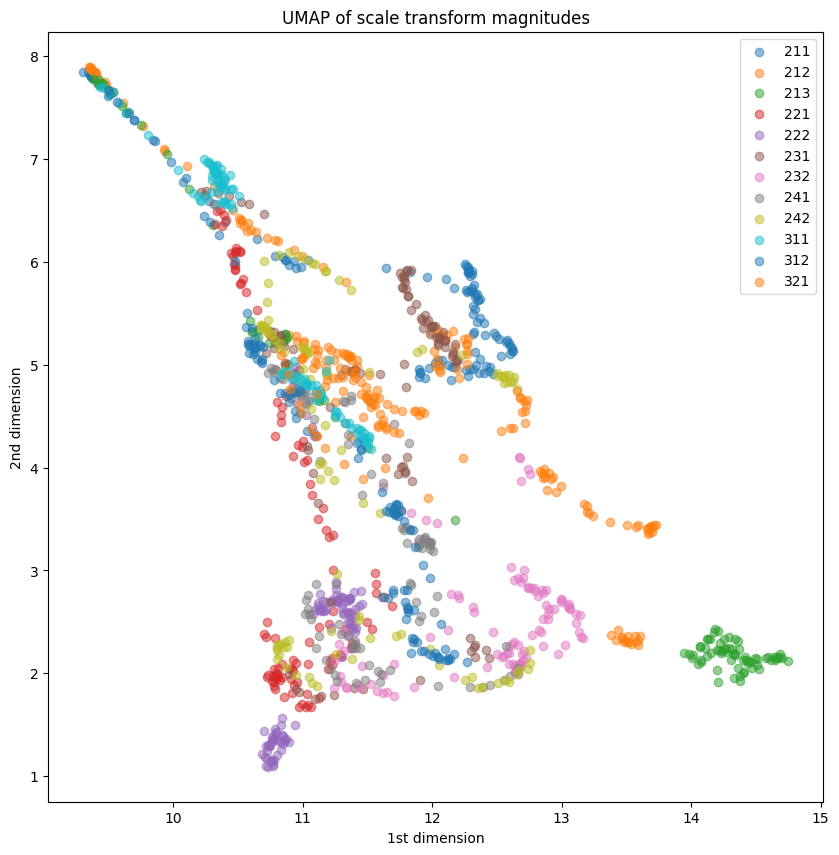

In [27]:
plt.figure(figsize=(10,10))
for g in np.unique(group):
    idx = np.where(group==g)
    plt.scatter(Xt[idx,0], Xt[idx,1], c=cdict[g], label=madera_labels[g], alpha=0.5)
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.title('UMAP of scale transform magnitudes')
plt.legend();